In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
kaggle_input_dir = '/kaggle/input'
kaggle_output_dir ='/kaggle/working'


# Problem and Data Description


The problem is to predict which Tweets describe a real disaster. This is not as easy as it may seem because people may use metaphors and are not talking about real disasters. The data is comprised of 10,000 tweets that were manually classified. The data is free form


In [3]:
# First start be reading in all the kaggle input files.
# We will use the sample_submission.csv file to create out submission file
train_data        = pd.read_csv(kaggle_input_dir + '/nlp-getting-started/train.csv')
test_data         = pd.read_csv(kaggle_input_dir + '/nlp-getting-started/test.csv')
sample_submission = pd.read_csv(kaggle_input_dir + '/nlp-getting-started/sample_submission.csv')

# Exploratory Data Analysis (EDA) and Plan for Analysis



In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The data shows that there are four columns that might be of interest. The column "text" is obviously important, however, let's also take a look at what kind of information can be found in keyword or location.

In [5]:
train_data[~train_data['keyword'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


The column keyword has values like ablaze that apply to both disasters and non-disasters. Keyword taken from the text but have no context, so it will not be useful to leverage keyword in the feature engineering. Likewise, the column location does not look very promising since the value simply indicate countrie or country / city.

In [6]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_data.info()
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [8]:
label_counts = train_data['target'].value_counts()
print(label_counts)
print(label_counts[0])

0    4342
1    3271
Name: target, dtype: int64
4342


<Axes: title={'center': 'Disaster Class Frequency'}, xlabel='Class', ylabel='Frequency'>

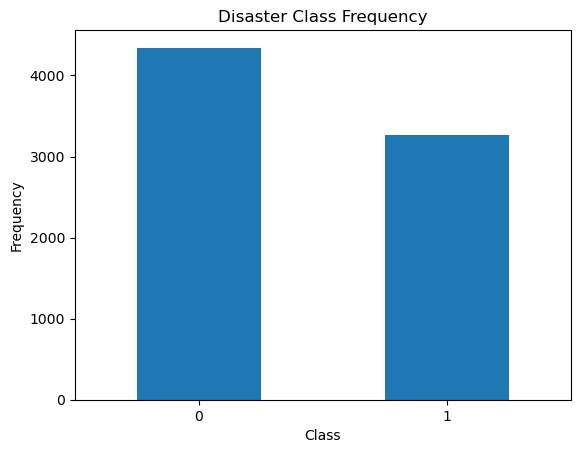

In [9]:
label_counts.plot.bar(rot=0, title = "Disaster Class Frequency", xlabel = "Class", ylabel = "Frequency")

There are more non-disaster lables, however, it is not so much that it should create a huge bias problem. We will first try training without downsampling non-disaster labels.

# Text preprocessing

We will remove HTML tags, urls, and expand abbrevations into their full words. We will also remove common small words, called stop words, like "the", "for", etc. using the NLT stopword list.

In [10]:
#Libraries for formattting and handling text 
import string 
import re

In [11]:
def remove_punc(text):

    
    clean_text = [char for char in text if char not in string.punctuation]
   
    clean_text = ''.join(clean_text)
    
        
    return clean_text

In [12]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",    
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",  
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",  
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",    
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
    
    

In [13]:
# remove hashtags
def remove_hashtag(text):
  return text.replace("#", "")

# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):   
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [14]:
def clean_tweet(text):

    text = remove_hashtag(text)
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # replace abbreviations, @ and number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

In [15]:
train_data["clean_text"] = train_data["text"].apply(clean_tweet)

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
#train_data['clean_text'] = preprocess_text_col(train_data, "text")
#train_data.head()
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train_data.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason earthquake May ALLAH Forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked 'shelter place' notified o...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby Alaska smoke wildfire...


In [18]:
test_data["clean_text"] = test_data["text"].apply(clean_tweet)
test_data['clean_text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_data.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,Just happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard #earthquake different cities, stay safe ..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 China Taiwan


# 

In [19]:
# determine size of training vocabulary

tok = tf.keras.preprocessing.text.Tokenizer(oov_token="<00V>")
sentences = train_data['clean_text'].to_numpy()
labels = train_data['target'].astype(int).to_numpy()
tok.fit_on_texts(sentences)
vocab_size = len(tok.word_counts)+1
print("vocabulary size: {:d}",format(vocab_size))

vocabulary size: {:d} 15000


In [20]:

seq_lengths = np.array([len(s.split()) for s in sentences])
print(max(seq_lengths))


28


In [21]:
# set initial hyper parameter values
VOC_SIZE = vocab_size
MAX_LEN = max(seq_lengths)
OOV_TOK = "<00V>"
BATCH_SIZE = 64
PADDING_TYPE = "post"
TRUNC_TYPE = "post"
EMBEDDING_SIZE = 16


In [22]:
# Split the sentences
training_size = round(len(sentences)*0.8)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [23]:
tok = tf.keras.preprocessing.text.Tokenizer(num_words=VOC_SIZE, oov_token=OOV_TOK)

# Generate the word index dictionary
tok.fit_on_texts(training_sentences)
word_index = tok.word_index

# Generate and pad the training sequences
training_sequences = tok.texts_to_sequences(training_sentences)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
print(training_padded.shape)
# Generate and pad the testing sequences
testing_sequences = tok.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

(6090, 28)


# Model Architecture

Three model architectures are used order to compare performance of a vanilla MLP, LTSM, and Bidirectional LTSM, i.e. the last two models are RNNs. All three models use an Embedding layer with dimension 100. Embedding layer is critical for Deep Neural Networks (NN) that are used to solve NLP problems. 

The Embedding layer learns representations that give context words and how they relate to each other. The output of an embedding layer can be passed to a MLP layer, a CNN layer, or a LTSM layer. The later is what makes the model a RNN. The dimension needs to be large and many models start with a dimension size of 100. Average Pooling is used with Model 1 to help reduce overfitting. Dropouts are used with Model 2 and 3 to help reduce overfitting.

The number of permuations and comparions between models and hyperparamters is large, therefore hyperparameters have not been changed, and only model architectures have been compared.





In [24]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  


In [25]:
def create_submission(filename, data, tok, model, max_len):
    
    test_as_ints = tok.texts_to_sequences(data['text'])
    test_as_ints = tf.keras.preprocessing.sequence.pad_sequences(test_as_ints, max_len)
    predictions = model.predict(test_as_ints)
    binary_pred = (predictions > 0.5).astype(int)

    ids = data['id']
    # Save predictions to CSV file
    submission_df = pd.DataFrame({'id': ids, 'target': binary_pred.flatten()})
    submission_df.to_csv(filename, index=False)

In [26]:
def model1():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=MAX_LEN),
    #tf.keras.layers.Embedding(vocab_size, MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.summary()
    return model

In [27]:
def model2():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100, activation="relu",dropout=0.2, recurrent_dropout=0.2 ),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.summary()
    return model

In [28]:
#def model2():
#    model = tf.keras.models.Sequential([
#    tf.keras.layers.Embedding(vocab_size, 100),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation="relu")),
#    tf.keras.layers.Dense(24, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#    ])

#    model.compile(
#        loss="binary_crossentropy",
#        optimizer="adam",
#        metrics=["accuracy"]
#    )
#    model.summary()
#    return model


In [29]:
#def model2b():
#    model = tf.keras.models.Sequential([
#    tf.keras.layers.Embedding(vocab_size, 100,input_length = MAX_LEN),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2 ),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.LSTM(100,dropout=0.2, recurrent_dropout=0.2),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(24, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#    ])
#    model.compile(
#        loss="binary_crossentropy",
#        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
#        metrics=["accuracy"]
#    )

#    print(model.summary())
#    return model

In [30]:
def model3():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2 )),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.summary()
    return model

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [32]:
model = model1()
hist1 = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping], verbose=2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 100)           1500000   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,502,449
Trainable params: 1,502,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 - 18s - loss: 0.6384 - accuracy: 0.6345 - val_loss: 0.5643 - val_accuracy: 0.7538 - 18s/epoch

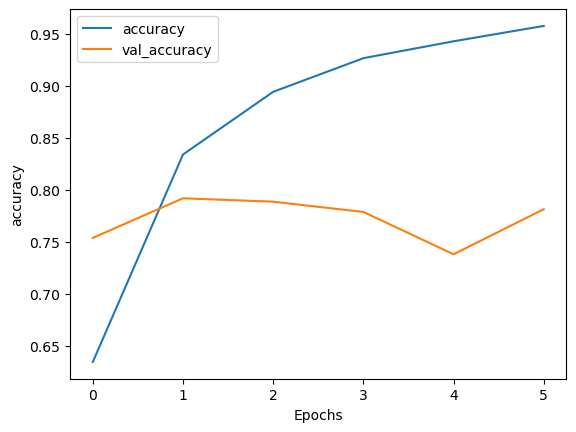

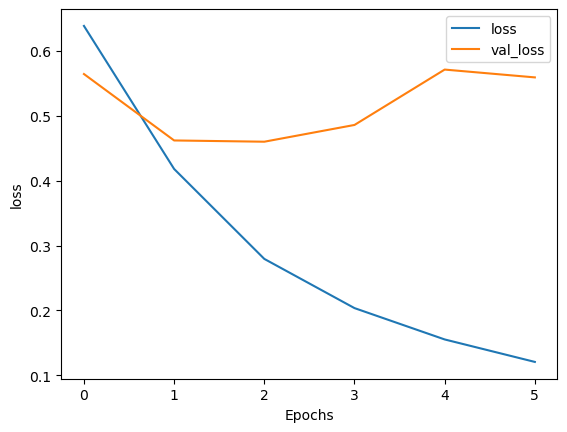

In [33]:
# Plot the accuracy and loss
plot_graphs(hist1, "accuracy")
plot_graphs(hist1, "loss")

In [34]:
# Create Kaggle submission file
# prepare test data


create_submission(kaggle_output_dir + '/submission_model.csv', test_data, 
                  tok, model, MAX_LEN)
# Kaggle public score 0.78486 V14


102/102 [==============================] - 0s 1ms/step


In [35]:

model = model2()
hist2 = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping], verbose=2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1500000   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 24)                2424      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,582,849
Trainable params: 1,582,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 - 34s - loss: 0.6621 - ac

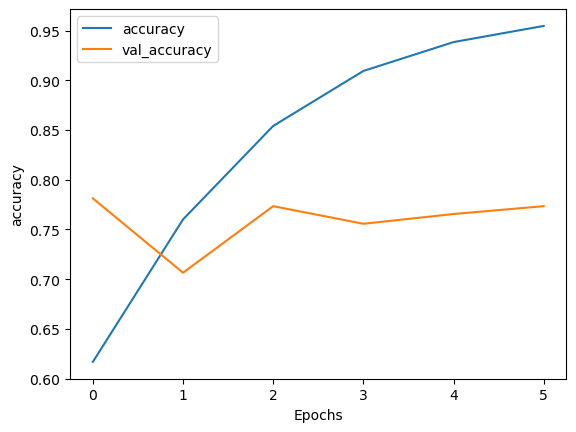

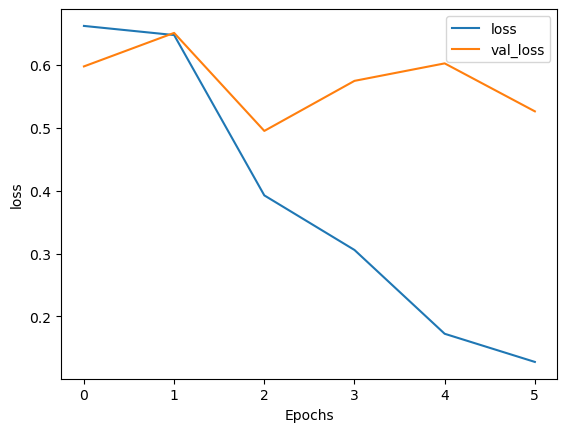

In [36]:
# Plot the accuracy and loss
plot_graphs(hist2, "accuracy")
plot_graphs(hist2, "loss")

In [37]:
# Create Kaggle submission file
# prepare test data


create_submission(kaggle_output_dir + '/submission_model2.csv', test_data, 
                  tok, model, MAX_LEN)
# Kaggle public score 0.57033 - default activation - sigmoid
# Kaggle public score 0.68127 - relu activation
# Kaggle public score 0.75697 less dense


102/102 [==============================] - 1s 8ms/step


In [41]:

model =  model3()
hist3 = model.fit(training_padded, training_labels, epochs=20, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping], verbose=2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1500000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 24)                4824      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,665,649
Trainable params: 1,665,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
191/191 - 54s - loss: 0.5351 - accuracy: 0.7225 - val_loss: 0.4644 - val_accuracy: 0.7905 - 54s/epo

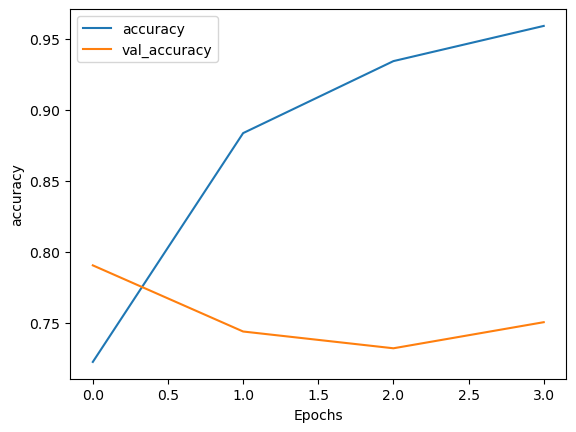

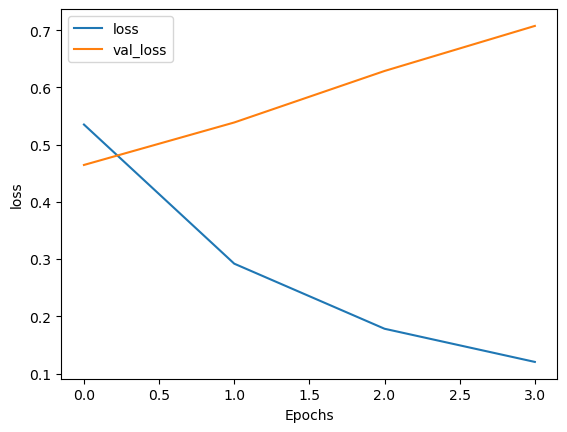

In [42]:
# Plot the accuracy and loss
plot_graphs(hist3, "accuracy")
plot_graphs(hist3, "loss")

In [43]:

create_submission(kaggle_output_dir + '/submission_model3.csv', test_data, 
                  tok, model, MAX_LEN)



102/102 [==============================] - 2s 15ms/step


# Results and Analysis

<table>
  <tr>
    <th>Model</th>
    <th>Training Accuracy</th>
    <th>Validation Accuracy</th>
    <th>Kaggle Public Score</th>
  </tr>

  <tr>
    <td>Model1</th>
    <td>95.76%</td>
    <td>78.14%</td>
    <td>75.64%</td>
  </tr>

  <tr>
    <td>Model2</th>
    <td>95.48%</td>
    <td>77.35%</td>
    <td>74.5%</td>
  </tr>
  <tr>
    <td>Model3</th>
    <td>95.93%</td>
    <td>75.1%</td>
    <td>74.9%</td>
  </tr>
</table>


# Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?